# Yes/No 音声認識

ref. https://www.tensorflow.org/tutorials/audio/simple_audio  
ref. https://aidemy.net/magazine/661/  

In [1]:
import sys
import pyaudio
import wave
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import recorder
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
np.random.seed(seed)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
# 録音して自分の声をyes/no各20サンプル作成(固定長)
n_datas = 20
samplerate = 16000
rec_seconds = 2
data_dir = "./data/yes_no_detection"

In [ ]:
# 対話形式で生成
print("start")

print("input filename prefix:")
filename_prefix = str(input())
print(filename_prefix)
assert filename_prefix in ["yes", "no"]
print("input start index:")
index = int(input())
print(index)
while True:
    print("input Enter to rec or 'end' to end:")
    if input() == 'end':
        print("end")
        break
    rec = recorder.Recorder(channels=1, rate=samplerate)
    rec.record(rec_seconds, f'{data_dir}/{filename_prefix}_{index}.wav')
    rec.close()
    index += 1
    print(f"next: {index}")


In [16]:
# 録音ファイルをロード
X_no = []
X_yes = []
for i in range(n_datas):
    no, _ = librosa.load(f'{data_dir}/no_{i}.wav', sr=samplerate, mono=True)
    yes, _ = librosa.load(f'{data_dir}/yes_{i}.wav', sr=samplerate, mono=True)
    X_no.append(no)
    X_yes.append(yes)

In [17]:
print('Audio playback')
display.display(display.Audio(X_no[0], rate=samplerate))

Audio playback


In [18]:
def plot_samples(X, label):
    # case of n = 20
    rows = 4
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    fig.suptitle(f"Waveform of '{label}'", fontsize=20)

    n = rows * cols
    for i, x in enumerate(X):
        r = i // cols
        c = i % cols
        ax = axes[r][c]
        ax.plot(x)
        ax.set_yticks(np.arange(-1.2, 1.2, 0.2))

        if i+1 >= n:
            break

    plt.show()
    

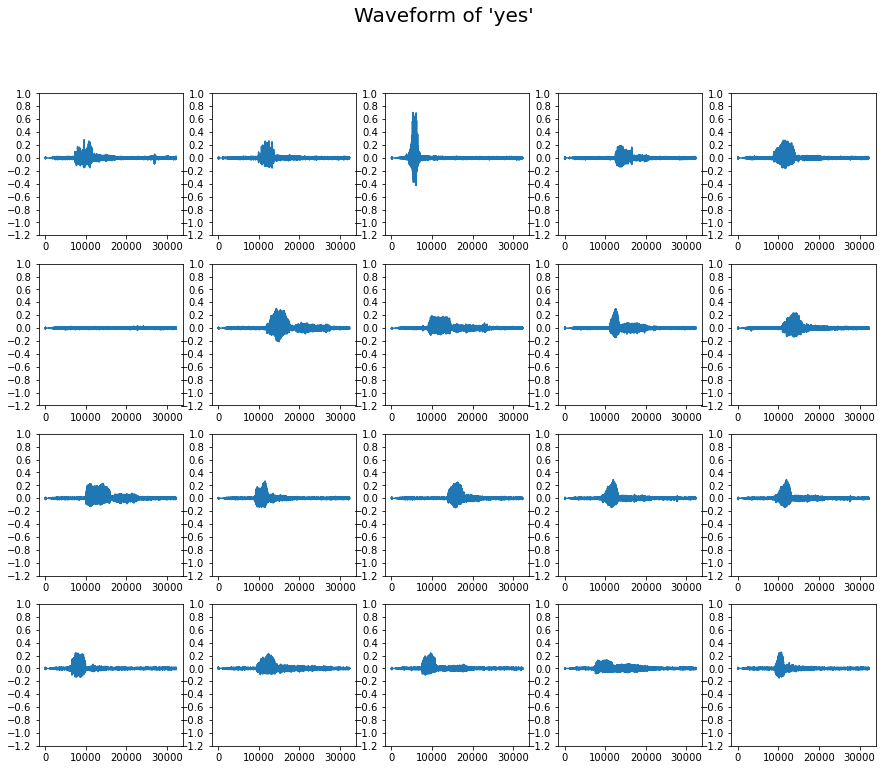

In [19]:
# 波形をプロット
plot_samples(X_yes, "yes")

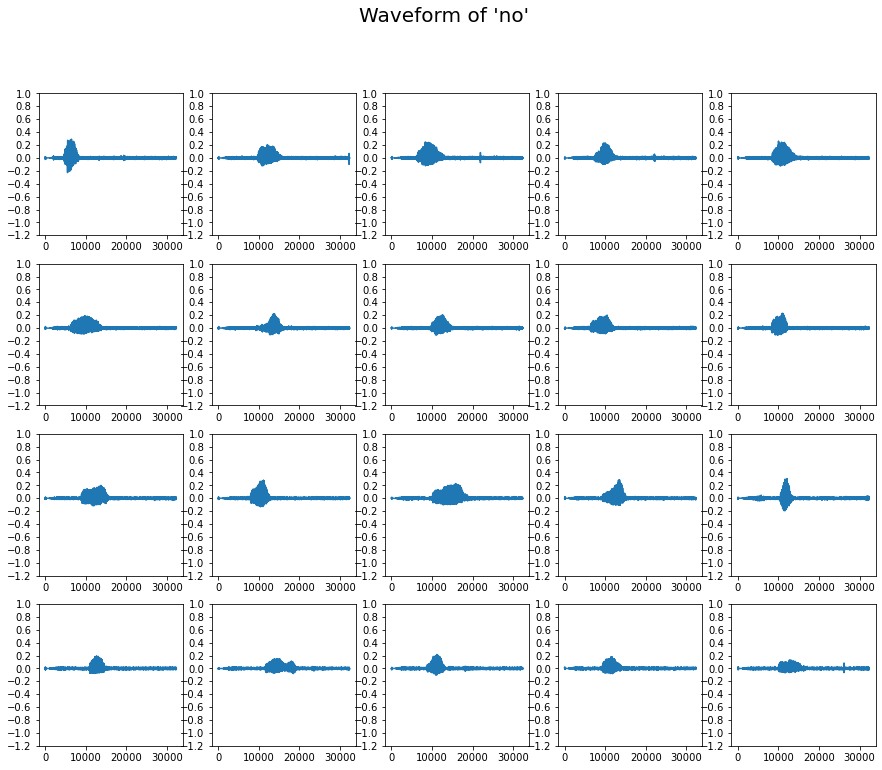

In [20]:
# 波形をプロット
plot_samples(X_no, "no")